In [1]:
import pandas as pd
import numpy as np

field = "Econ"
df = pd.read_csv("distances_econ.csv") # Relevance based
df2 = pd.read_csv("predictions_Econ.csv") # Recommender system based

#predictions include only authors with at least 15 venues, so remove from relevance authors not in predictions
df3 = df[df.AID.isin(df2.AID)]

In [1]:
def rank_distances(df, aid):
    df = df[df.index==aid].reset_index()
    df = df.set_index('AID').T
    df.columns = ['Values']
    #v_list = df.sort_values(by=aid, ascending=False, axis=1)
    v_list = df.sort_values(by='Values', ascending=False, axis=0)
    venues = pd.DataFrame()
    venues['VID'] =  list(v_list.index)
    r_vals = v_list['Values'].values
    
    venues['Relevance'] = r_vals
    #flip the values
    venues['Relevance'] = 1/(1+venues['Relevance'])
    #normalize
    venues['Relevance'] = 100*venues['Relevance'] / venues['Relevance'].sum()
    
    venues = venues.head(n=200)
    return venues

def rank_citations(df, aid):
    df = df[df.AID==aid]
    df = df.sort_values(by='Citations')
    
    #normalize values
    df['Citations'] = 100*df['Citations'] / df.Citations.sum()
    
    return df[['VID','Citations']]


In [725]:
# Finding probabilistic versions

Tau=.1
v2_distances=deepcopy(v_distances)
v2_citations=deepcopy(v_citations)

Rel=np.exp(v2_distances.Relevance/Tau)
v2_distances.Relevance=-np.log(Rel/Rel.sum())

Rel=np.exp(v2_citations.Citations/Tau)
v2_citations.Citations=-np.log(Rel/Rel.sum())

In [726]:
# Woon hack

authors = list(df3.head(n=100)['AID'].values)
df4 = df3.set_index("AID") #Remove AID as column and set is as index
df4 = df4[df2.VID.unique()] #Remove conferences not in prediction from distances

real_data = pd.read_csv("../data/"+field+"/"+field+"AIDPIDVIDANameVName.csv")


print len(authors)
cnt = 1



100


In [727]:
#rank_citations(df2,author)
rank_citations(df2,author).head()

,VID,Citations
75999,005B51E1,200
75998,07A86E0B,199
75997,0608554B,198
75996,08254938,197
75995,0B75E22E,196


In [731]:
# Woon hack
authors = list(df3['AID'].values)
def calc_R_C_woon(r, c, rp, cp, col,Tau=1):
    r = r.merge(c, on="VID", how="outer") #to include all VIDs
    r = r.fillna(0)
    r[col] = r['Relevance']*rp + r['Citations']*cp
    
    Rel=np.exp(r[col]/Tau)
    r[col]=-np.log(Rel/Rel.sum())
    
    return r[['VID',col]]

results = pd.DataFrame()
#authors_=[authors[1]]
cnt=0
for author in authors:
    
    if cnt%100==0:
        print cnt
    cnt = cnt+1
    
    v_citations = rank_citations(df2,author)
    
    v_distances = rank_distances(df4,author)
    v_distances.VID = np.random.permutation(v_distances.VID)
    
    v_real = real_data[real_data.AID==author]
    
    #calc the different combinations of recommendations for the author
    temp = v_distances.merge(v_citations, on="VID", how="outer")
    temp = temp.fillna(0)
    temp = calc_R_C_woon(v_distances, v_citations, 1, 0, 'R100_C0')
    temp2 = pd.DataFrame()
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.9, 0.1, 'R90_C10')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.8, 0.2, 'R80_C20')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.7, 0.3, 'R70_C30')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.6, 0.4, 'R60_C40')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.5, 0.5, 'R50_C50')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.4, 0.6, 'R40_C60')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.3, 0.7, 'R30_C70')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.2, 0.8, 'R20_C80')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0.1, 0.9, 'R10_C90')
    temp = temp.merge(temp2, on="VID")
    temp2 = calc_R_C_woon(v_distances, v_citations, 0, 1, 'R0_C100')
    temp = temp.merge(temp2, on="VID")
    
    #add the real results, T or F if author published in venue or not
    temp['Real'] = temp.VID.isin(v_real.VID.values)
    temp = temp[temp.Real] #extract rows of the author with venues used in real data
    
    #print temp
    
    #extract rows of venues in author's real data only
    vc = v_real[['VID','AID']].groupby("VID").count().reset_index().rename(columns={'AID':'VIDCount'})
    temp = temp.merge(vc, on="VID")
    
    #pdb.set_trace()
    
    #calculate the similarity index (softmax) for each combination
    tau = 1
    
    mixes = ['R100_C0','R90_C10','R80_C20', 'R70_C30', 'R60_C40', 'R50_C50', 'R40_C60', 'R30_C70', 'R20_C80', 'R10_C90', 'R0_C100']
    
    #for m in mixes:
    #    temp['e_'+m] = np.exp(temp[m]/tau)
    #    temp['sum_e_'+m] = temp['e_'+m]*temp['VIDCount']
    #    temp['Sim_'+m] = -1*np.log(temp['e_'+m] / temp['sum_e_'+m].sum())
    
    #temp is the results of each individual author
    #calc sim index by adding each column
    #res = pd.DataFrame()
    #res.set_value(0,'AID', author)
    
    res=pd.DataFrame([(temp[mixes]*np.tile(temp.VIDCount.values.reshape((-1,1)),(1,11))).sum()])/temp.VIDCount.sum()
    res['AID']=author
    #for m in mixes:
    #    res['Sim_'+m] = temp['Sim_'+m].sum()
    
    results = results.append(res)

0
100
200
300
400
500
600
700
800
900
1000


In [732]:
import matplotlib.pyplot as plt
%matplotlib inline

mixes = ['R100_C0','R90_C10','R80_C20', 'R70_C30', 'R60_C40', 'R50_C50', 'R40_C60', 'R30_C70', 'R20_C80', 'R10_C90', 'R0_C100']

max_sim = results[['R100_C0','R90_C10','R80_C20', 'R70_C30', 'R60_C40', 'R50_C50', 'R40_C60', 'R30_C70', 'R20_C80', 'R10_C90', 'R0_C100']].max().max()
max_min = results[['R100_C0','R90_C10','R80_C20', 'R70_C30', 'R60_C40', 'R50_C50', 'R40_C60', 'R30_C70', 'R20_C80', 'R10_C90', 'R0_C100']].min().min()

for m in mixes:
    results['Norm_'+m] = results[m].apply(lambda x: (max_sim-x)/(max_sim-max_min))
    
plot = pd.DataFrame()
plot['relevance'] = range(100,-1,-10)

l = []
for m in mixes:
    l.append(results['Norm_'+m].mean())
    
plot['average_similarity_index'] = l

plot

R100_C0     200.459
R90_C10     183.538
R80_C20     178.133
R70_C30     175.034
R60_C40     173.833
R50_C50     173.115
R40_C60     173.444
R30_C70      176.64
R20_C80     183.763
R10_C90     191.434
R0_C100     200.459
AID        85EBFEF8
dtype: object


,relevance,average_similarity_index
0,100,0.402794
1,90,0.438806
2,80,0.458793
3,70,0.474186
4,60,0.486759
5,50,0.497205
6,40,0.505736
7,30,0.512254
8,20,0.516294
9,10,0.515935


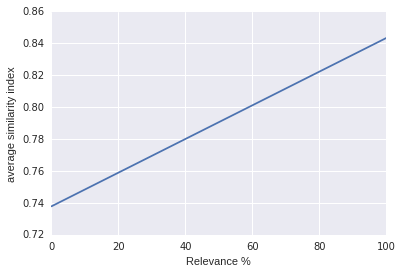

In [685]:
plt.plot(plot['relevance'], plot['average_similarity_index'])

plt.xlabel('Relevance %')
plt.ylabel('average similarity index')

#plt.ylim(0,1)

plt.savefig("../data/images/rel_sim_tau"+str(tau)+"_temp.pdf", format="pdf")